# Логистическая регрессия

## Подготовка данных

### 2D-датасет

Генерация датасета из 700 наблюдений с двумя признаками и зависимой переменной

In [1]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5, 
                           random_state=42)

Проверяем размерность пространства признаков и таргетов

In [2]:
X.shape, y.shape

((700, 2), (700,))

Выборка делится на несколько частей:

train — для обучения модели (поиска коэффициентов)

test — для проверки качества моделей

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Можно сразу посмотреть на ROC AUC признаков

In [4]:
from sklearn.metrics import roc_auc_score
round(roc_auc_score(y_train, X_train[:, 0]), 3), round(roc_auc_score(y_train, X_train[:, 1]), 3)

(0.543, 0.762)

Отрисуем совместное распределение двух признаков. Разными цветами обозначены разные целевые переменные

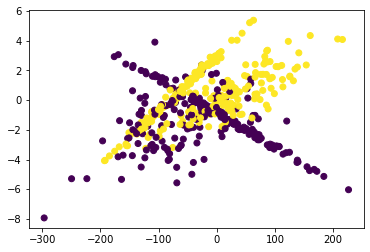

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

Обучение модели происходит так:

Объявляем объект нужного класса, в нашем случае LogisticRegression. Для начала без регуляризации (penalty='none')

У объекта есть метод fit, принимающий на вход матрицу признаков и вектор целевых переменных

После этого в объекте класса содержится обученная модель

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none')
clf.fit(X_train, y_train)

LogisticRegression(penalty='none')

Визуализируем наши данные и прямую, отделяющую класс "0" от класса "1"

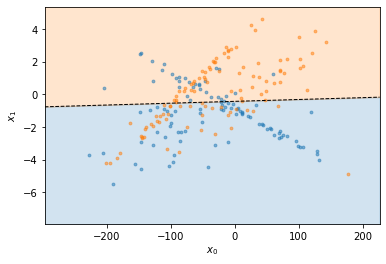

In [7]:
# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = min(X_train[:, 0]), max(X_train[:, 0])
ymin, ymax = min(X_train[:, 1]), max(X_train[:, 1])
xd = [xmin, xmax]
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X_test[y_test==0].T, s=8, alpha=0.5)
plt.scatter(*X_test[y_test==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_1$')
plt.xlabel(r'$x_0$')

plt.show()

## Датасет с 10 переменными

### Генерация

Теперь попробуем создать данные с 10 признаками и 700 наблюдениями

Информативных из них 5, остальные — шум

На выходе получаем матрицу признаков и вектор целевых переменных

In [8]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=700, n_features=10, n_informative=5, n_redundant=0,
                           n_repeated=0, scale=None, shift=None, shuffle=False, random_state=42, class_sep=0.5)

### Разделение на обучающую выборку и тестовую

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

## Обучение модели

### Попробуем с дефолтными параметрами

In [11]:
from sklearn.linear_model import LogisticRegression

model_one = LogisticRegression(max_iter=10000)
model_one.fit(X_train, y_train)
res = model_one.predict_proba(X_test)[:,1]

round(roc_auc_score(y_test, res), 3)

0.736

In [12]:
model_one.coef_

array([[-0.00991278, -0.00191979,  0.00231835,  0.01251228,  0.00577563,
        -0.00010078, -0.00010067,  0.00532664, -0.00456097,  0.00040419]])

In [13]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([ 12.0505918 ,  -3.72760318,   5.45749603,   1.22164414,
          8.35652366, -17.28406499, -12.60707744,   0.56987723,
         -2.65455251,   2.31284034]),
 array([ 27.95253613, 115.8163779 ,  34.8854663 ,  25.81667512,
         75.62980156,  51.21091491,  22.36871823,  25.73312175,
         18.12437408,  71.12146204]))

In [14]:
model_one.coef_

array([[-0.00991278, -0.00191979,  0.00231835,  0.01251228,  0.00577563,
        -0.00010078, -0.00010067,  0.00532664, -0.00456097,  0.00040419]])

Видим, что у признаков совершенно разная дисперсия

В таких условиях регуляризация будет по-разному влиять на переменные.

Чем больше дисперсия, тем меньше будет коэффициент и тем слабее регуляризация ослабляет коэффициент. 
Нужно все признаки привести к единому масштабу

### Нормировка

In [15]:
from sklearn.preprocessing import StandardScaler

Для нормировки используем StandardScaler.

Принцип работы: вычесть из каждого признака его среднее, и разделить на стандартное отклонение

Получим набор признаков со средним в 0 и единичным стандартным отклонением

Метод позволяет выучить нужное преобразование на обучающей выборке, а применить к обучающей и тестовой

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
model_two = LogisticRegression(max_iter=10000)
model_two.fit(X_train, y_train)
res = model_two.predict_proba(X_test)[:,1]

round(roc_auc_score(y_test, res), 3)

0.737

In [18]:
model_two.coef_

array([[-0.27362525, -0.22180106,  0.07994113,  0.32036025,  0.43203386,
        -0.00509724, -0.00196087,  0.13559046, -0.08194319,  0.02844342]])

Коэффициенты теперь соответствуют силе переменной. Чем больше коэффициент, тем больший вклад в отклонение предсказания вносит признак

### Регуляризация

In [25]:
model_with_reg = LogisticRegression(max_iter=10000, solver='saga', penalty='l1', C=0.3)
model_with_reg.fit(X_train, y_train)
y_prob = model_with_reg.predict_proba(X_test)[:,1]
y_pred = model_with_reg.predict(X_test)

round(roc_auc_score(y_test, y_prob), 3)

0.733

In [26]:
model_with_reg.coef_, model_with_reg.intercept_

(array([[-0.25376308, -0.19430149,  0.02883771,  0.27012697,  0.42202767,
          0.        ,  0.        ,  0.10380313, -0.05329772,  0.        ]]),
 array([-0.01125465]))

Регуляризация не всегда улучшает качество модели, но позволяет избавиться от ненужных переменных. Это положительно сказывается на стабильности модели во времени, простоте реализации и поддержки

In [27]:
from sklearn.metrics import accuracy_score, f1_score
round(accuracy_score(y_test, y_pred), 3), round(f1_score(y_test, y_pred), 3)

(0.643, 0.645)

# Визуализация

## ROC AUC curve

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, res)

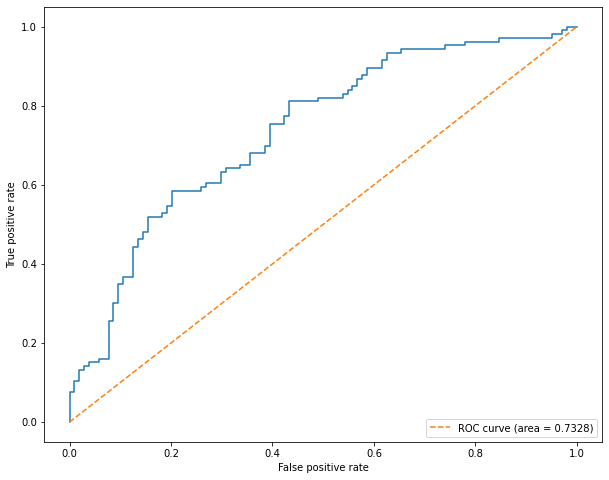

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot([0,1], [0,1], linestyle='dashed', label="ROC curve (area = %0.4f)" % roc_auc_score(y_test, y_prob))
plt.legend(loc='lower right')
plt.show()

## Матрица ошибок

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

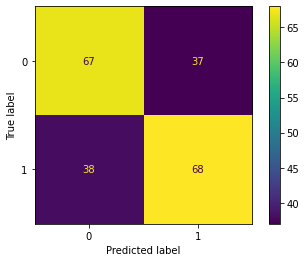

In [31]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()